# Functions needed to compute u*

In [42]:
# import scipy.optimize
# import autograd.numpy as np
# import autograd
import numpy as np
from numpy.linalg import matrix_power

# Functions for construction of problem

# Assume Noise i.i.d. logistic random variables with mean 0
def cap_psi(X, g):
    # g - gamma
    # cdf of zero-mean logistic random var
    return np.reciprocal(np.exp(-1.0/g*X)+1.0)

def psi(X,g):
    # g - gamma
    # pdf of zero-mean logistic random var
    return 1.0/g*np.exp(-1.0/g*X)*np.reciprocal(np.exp(-1.0/g*X)+1)**2

# Weight function returned by kernel Function
def weight(X, N_lst, r, eps):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use
    eps - gives perturbed kernel if eps != 0
    r - threshold in kernel function
    '''
    # Weight returned using perturbed kernel function k_eps(|x_i - x_j|) [1]-(61)
    N = N_lst.size
    W = np.zeros((N,N))
    for count_i,i in enumerate(N_lst):
        for count_j, j in enumerate(N_lst):
            # kappa function as L2 norm
#             X_i = X[i]; X_j = X[j]
#             dist = 0.0
#             for ix in range(X_i.size):
#                 dist += (X_i[ix]-X_j[ix])**2
            dist = np.linalg.norm(X[i]-X[j])**2
            if dist<=r:
                W[count_i][count_j] = 1
            W[count_i][count_j] += eps*np.exp(-dist/(r+eps)**2)

    np.fill_diagonal(W, 0)
    return W

# Inverse of covariance
def Cov_inv(X, N_lst, eps, alpha, tau, r):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    r - threshold in kernel function
    '''
    N = N_lst.size
    W = weight(X,N_lst,r,eps)
    D = np.diag(W.sum(axis=1))
    L = D - W
    return matrix_power(1/tau**2*(L + tau**2*np.eye(N)), int(alpha))

In [43]:
import ray
from ray import tune
from ray.tune.suggest.bayesopt import BayesOptSearch

# -----------Newton's Method----------------------------------

def misfit(u, N_lst, y, Z_p, g):
    '''
    Misfit function defined in [3]-(45)
    u - vector to find
    N_lst - list of indices used
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    S = 0.0
    for j,Z_j in enumerate(Z_p):
        u_j = np.where(N_lst == Z_j)
        S = S - np.log(cap_psi(y[j]*u[u_j][0],g))
    return S

def probit_min(X, N_lst, y, Z_p, u, g, alpha, tau, eps, rval):

    if type(N_lst) == int:
        N_lst = np.arange(N_lst)

    C_inv = Cov_inv(X, N_lst, eps, alpha, tau, rval)
    # Minimizer u for problem defined in [3]-(3)
    ret = 1/2*np.dot(u, np.matmul(C_inv,u)) + misfit(u, N_lst, y, Z_p, g)
    return ret

# Set up Data

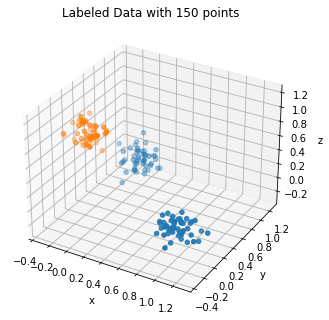

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

N_each = 50 # Number of points in each cluster
n_cluster = 3 # Number of clusters
N = N_each*n_cluster # Total number of points

mu, sigma = 0, 0.1 # mean and standard deviation
xs = np.random.normal(mu, sigma, N)
ys = np.random.normal(mu, sigma, N)
zs = np.random.normal(mu, sigma, N)

# Cluster centers: (1,0,0) (0,1,0) (0,0,1)
xs[:N_each] += 1; ys[N_each:2*N_each] += 1; zs[2*N_each:3*N_each] += 1
Data = np.array([xs,ys,zs]).T

u_dagger = np.append(np.ones(2*N_each), -1*np.ones(N_each))
Z_prime = np.array([0,50,100]) # Indices of labels
y = np.sign(u_dagger[Z_prime]) # One label is observed within each cluster

# Display plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs[:2*N_each], ys[:2*N_each], zs[:2*N_each], 'r')
ax.scatter(xs[2*N_each:3*N_each], ys[2*N_each:3*N_each], zs[2*N_each:3*N_each], 'b')
ax.set_title('Labeled Data with ' + str(N) +' points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.show()

In [45]:
#defining trainable function that minimizes probit function
def trainable(config):
    maxiter = 50
    for __ in range(maxiter):
        u = np.random.normal(mu, sigma, N)
        result = probit_min(Data, N, y, Z_prime, u, config["g"], config["alpha"], 
                   config["tau"], config["eps"], config["rval"])
        tune.report(score = result)
        
        # Define the search space
config = {
    "g": tune.uniform(0,1.5),
    "alpha": tune.uniform(0, 6),
    "tau": tune.uniform(0, 6),
    "eps": tune.uniform(0, 1),
    "rval": tune.uniform(0, 1.5)
}

In [46]:
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.suggest.bayesopt import BayesOptSearch

bayesopt = BayesOptSearch(metric = "score", mode="min")
analysis = tune.run(trainable, config = config, search_alg=bayesopt, num_samples=5, verbose = 0)


2021-11-29 16:39:44,301	WARNING bayesopt.py:397 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2021-11-29 16:39:44,302	WARNING bayesopt.py:397 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2021-11-29 16:39:44,304	WARNING bayesopt.py:397 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2021-11-29 16:39:44,305	WARNING bayesopt.py:397 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2021-11-29 16:39:44,307	WARNING bayesopt.py:397 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.


In [47]:
# Get a dataframe for the last reported results of all of the trials
df = analysis.results_df

# Get a dataframe for the max accuracy seen for each trial
df = analysis.dataframe(metric="score", mode="min")

# Get a dict mapping {trial logdir -> dataframes} for all trials in the experiment.
all_dataframes = analysis.trial_dataframes

# Get a list of trials
trials = analysis.trials

In [48]:
df_results

,score,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,time_total_s,...,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config.g,config.alpha,config.tau,config.eps,config.rval
trial_id,,,,,,,,,,,,,,,,,,,,,
f056c142,24452.091985,0.957936,True,None,None,50,8a339c33a0da4f9aaca41b67991a90db,2021-11-29_16-22-07,1638170527,48.323526,...,127.0.0.1,48.323526,0,50,"1_alpha=2.2472,eps=0.95071,g=1.098,rval=0.8979...",1.097991,2.247241,0.936112,0.950714,0.897988
f1b8a9c4,2.833391,0.936788,True,None,None,50,7efe962b9b384094aef3b3820aaaf2cd,2021-11-29_16-22-09,1638170529,49.972620,...,127.0.0.1,49.972620,0,50,"2_alpha=0.93597,eps=0.058084,g=1.2993,rval=0.9...",1.299264,0.935967,4.248435,0.058084,0.901673
f1cba25e,2.798300,0.889786,True,None,None,50,ebaedcdd942e4330a00840c6953a5e59,2021-11-29_16-22-09,1638170529,47.140068,...,127.0.0.1,47.140068,0,50,"3_alpha=0.12351,eps=0.96991,g=1.2487,rval=0.31...",1.248664,0.123507,1.090950,0.969910,0.318509
f3024826,18.928734,0.625233,True,None,None,50,4ef0083c49f348b7819746ca15b7cd08,2021-11-29_16-22-11,1638170531,49.438268,...,127.0.0.1,49.438268,0,50,"4_alpha=1.1004,eps=0.30424,g=0.78713,rval=0.64...",0.787135,1.100427,1.747375,0.304242,0.647918
f30951d4,400.500745,0.549394,True,None,None,50,ad7e8f05fcf94fe393cbf36f771c1452,2021-11-29_16-22-32,1638170552,22.308608,...,127.0.0.1,22.308608,0,50,"5_alpha=3.6711,eps=0.13949,g=0.43822,rval=0.54...",0.438217,3.671117,2.736420,0.139494,0.549543


In [59]:
# Not bayesian
config = {
    "g": tune.uniform(0,1.5),
    "alpha": tune.randint(0, 6),
    "tau": tune.uniform(0, 6),
    "eps": tune.uniform(0, 1.5),
    "rval": tune.uniform(0, 1.5)
}
analysis = tune.run(trainable, config = config, mode = 'min', metric = 'score', num_samples=5, verbose = 0)


(scheduler +1h4m42s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


In [60]:
best_trial = analysis.best_trial  # Get best trial
best_config = analysis.best_config  # Get best trial's hyperparameters
best_logdir = analysis.best_logdir  # Get best trial's logdir
best_result = analysis.best_result  # Get best trial's last results
best_result_df = analysis.best_result_df  # Get best result as pandas dataframe

In [61]:
best_config

{'g': 1.4411360107661837,
 'alpha': 1,
 'tau': 3.661087872164698,
 'eps': 1.0851065895342247,
 'rval': 1.1023347785115254}